In [1]:
### IMPORTS 

import warnings
warnings.filterwarnings("ignore")

import os

import pandas as pd
import numpy as np

import datetime as dt
from dateutil.parser import parse

import statsmodels.tsa as tsa
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from functools import reduce

Matplotlib is building the font cache; this may take a moment.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


In [2]:
### IMPORT DATA 

base_path = r"D:\_workspace\PredGasPira\notebooks\data\trusted"
#-
mes_path = r"MES\mes_dia.csv" # producao realizada e planejada
comgas_path = r"COMGAS\comgas_dia.csv" # consumo corrigido e não corrigido comgas
pims_path = r"PIMS\consumo_area_dia.csv" # consumo medido na planta por area LAM e ACI
#-
coef_consumo = r"coef_consumo.csv"
predicao = r"cc_predicao.csv"
cc_metricas = r"cc_metricas.csv"
#-
mes = pd.read_csv(
    os.path.join(base_path, mes_path),
    parse_dates=['date'])

comgas = pd.read_csv(
    os.path.join(base_path, comgas_path),
    parse_dates=['date'])

pims = pd.read_csv(
    os.path.join(base_path, pims_path),
    parse_dates=['date'])

#####################################

areas = ['aci', 'tl1', 'tl2']

comgas = comgas.rename(columns={
    'unc_vol': 'totalizador_naocorrigido',
    'cor_vol': 'totalizador_corrigido'
})

#-

#pims_fix = corrige_consumo(pims, comgas[['date', 'totalizador_corrigido']], agg='d')
#pims_fix.drop('totalizador_corrigido',axis=1, inplace=True)

pims = pims.rename(columns={
    'gas_fea': 'gas_aci_fea',
    'gas_mlc': 'gas_aci_mlc'
})
#- 
mes.columns = [str.lower(x) for x in mes.columns.values]
#-
dfs = [pims, comgas[['date', 'totalizador_corrigido']], mes]

df = reduce(lambda left,right: pd.merge(left,right,on=['date']), dfs)
#-

df = df.rename(columns={
    'totalizador': 'total_pims',
    'totalizador_corrigido': 'total_comgas'
})

df['gas_aci_total'] = df[
    [c for c in df.columns.values if 'gas' in c and 'aci' in c]].sum(axis=1)

print(df.shape)
df.head()

(439, 14)


date  gas_aci_fea  gas_tl1  gas_tl2  gas_aci_mlc  gas_uti_aci  \
0 2019-08-01      9092.94  10558.7  30421.7        513.0      10303.0   
1 2019-08-02      9635.09  36529.7  33559.8        506.0      11755.0   
2 2019-08-03     11076.20  32132.0  26355.0        707.0      11091.0   
3 2019-08-04     10795.60  29175.9  27448.7        791.0      12183.6   
4 2019-08-05      9434.88  27781.2  19888.2        414.0      13102.4   

   total_comgas  peso_planejado_tl1  peso_planejado_tl2  peso_realizado_tl1  \
0       63635.0               180.0              1650.0             184.109   
1       97156.0              1550.0              1650.0            1506.276   
2       85724.0              1500.0              1800.0            1422.949   
3       84364.0              1420.0              1800.0            1385.350   
4       74926.0              1250.0              1440.0            1209.360   

   peso_realizado_tl2  peso_planejado_aci  peso_realizado_aci  gas_aci_total  
0            1628.230              2660.0            3025.295       19908.94  
1            1734.437              2660.0            3009.708       21896.09  
2            1829.169              3500.0            3613.350       22874.20  
3            2028.948              3360.0            3609.099       23770.20  
4            1402.609              2240.0            2305.459       22951.28

# EDA - UNIVARIADA

## Plots Def

### F: Análise da Tendência (TREND)

* Monthly Distribuition
* Rolling Mean

In [3]:
df['gas_aci_total'] = df[[c for c in df.columns.values if 'gas' in c and 'aci' in c]].sum(axis=1)

In [4]:
def timeplot(ts, index_col='date', ax=None):
    """
    Plots the timeplot for a given timeseries
    
    """
    
    #ts = ts.set_index(index_col).iloc[:,0]
    
    var = [c for c in ts.columns.values if c !=index_col][0]
    
    sns.lineplot(data=ts, x=index_col, y=var, ax=ax)
    ax.title.set_text(f'{var} timeplot')
    
def trend_boxplot(data, y, ax, index_col='date', agg='M'):
    """
    Generates the boxplot for a timeseries
    """
    
    #data = data.set_index(index_col)
    
    if agg == 'M':
        data[agg] = data[index_col].dt.month
    elif agg == 'Y':
        data[agg] = data[index_col].dt.year
    elif agg == 'Y-M':
        data['year'] = data[index_col].dt.year
        data['month'] = data[index_col].dt.month
        data[agg] = data.apply(
            lambda row: str(row['year']) + '-' + str(row['month']), axis=1)
    else:
        print(f'Agg {agg} method not available')
    
    red_square = dict(markerfacecolor='r', marker='s')
    sns.boxplot(y=y, x=agg, ax=ax, data=data)
    #ax.boxplot(data)
    plt.setp(ax.get_xticklabels(), rotation = (45), fontsize = 10, ha='right')
    ax.title.set_text(f'Boxplot')

def rolling_mean_plot(data, var, roll_win=30, min_win=22, ax=None):
    """
    Plots rolling mean for a give time series
    
    :param data: time series data
    :type data: pd.DataFrame
    :param var: name of the variable to compute rolling mean
    :type var: string
    :param roll_win: rolling window size
    :type roll_win: int
    :param min_win: minimum window size 
    :type min_win: int
    """
    
    roll = data[var].rolling(roll_win, min_periods=min_win).mean()
    sns.lineplot(roll.index, roll.values, ax=ax)
    #ax.plot(roll.index, roll.values, label=f'{var} rolling mean')
    #plt.setp(ax.get_xticklabels(), rotation = (45), fontsize = 10, ha='right')
    ax.title.set_text(f'{var} rolling mean')

def trend_plots(ts, timestamp='date', series=None, s='M', fig_size=(12,8)):
    
    #fig = plt.figure(figsize=(12,8))
    #ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
    #ax2 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
    #ax3 = plt.subplot2grid((2, 3), (0, 2), rowspan=3)
    
    fig = plt.figure(figsize=fig_size, constrained_layout=True)
    
    fig.suptitle(f"Trend Analysis - {series}", fontsize=20, y=1.08)
    
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[:, 1:])
    
    
    timeplot(ts, timestamp, ax=ax1)
    rolling_mean_plot(ts, series, ax=ax2)
    trend_boxplot(ts, series, ax=ax3, agg=s)
           
    
    

### F: Análise da Sazonalidade

* Seasonality Plots
    - Mensal (Ano-Mês)
    - Semanal (Week Of Month)
    - Dia da Semana (Week Day)

In [5]:
from math import ceil

def week_of_month(dt):
    """ 
    Small Hack that returns the week of the month 
    for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day

    adjusted_dom = dom + (1 + first_day.weekday()) % 7
    
    w = int(ceil(adjusted_dom/7.0))
    
    if w > 5:
        w = 5
    else:
        pass
    
    return w

def datetime_variables(data, index='date'):
    
    data = data.set_index(index)
    
    data['M'], data['Y'] = data.index.month, data.index.year
    data['Y-M'] = data.apply(
        lambda row: str(str(row['Y']) + '-' + str(row['M'])), axis=1)
    data['WD'] = data.index.weekday + 1 # adds one to make monday #1 day and sunday #7
    
    data = data.reset_index()
       
    data['WoM'] = data.apply(lambda row:
                             week_of_month(row[index]), axis=1)
    
    return data

def seasonality_line_plot(data:pd.DataFrame, var=None, index='date', s='M', cat='Y', ax=None):
    """
    
    Plots the seasonality plot for a given series 
    for the required season.
    
    :param data: pd.DataFrame of the data
    :param index: column to be used as index
    :param s: season
    :param cat: categorical variable higlight the seasons
    """
    
    #TODO: IMPLEMENT ASSERTION FOR M, Y, Y-M, WD, WoM
    
    data = datetime_variables(data, index)
    
    data = data.groupby([s, cat], as_index=False).sum()
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    else:
        pass
    
    sns.lineplot(data=data, x=s, y=var, hue=cat, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation = (0), fontsize = 10, ha='right')
    plt.setp(ax.get_yticklabels(), rotation = (0), fontsize = 10, ha='right')
    
    ttl_map = {'M': 'month', 'Y': 'year',
               'Y-M': 'Year-Month', 'WD': 'Weekday', 'WoM': 'Week Of Month'}
    
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='left', borderaxespad=0.)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5, fontsize=10)   
    ax.title.set_text(f'Seasonality plot - Season: {ttl_map[s]} - Time Series: {var}')

def season_swarm_plot(data:pd.DataFrame, var=None, index='date', s='M', cat='Y', ax=None):
    """
    
    Plots the seasonality swarm plot for a given series 
    for the required season.
    
    :param data: pd.DataFrame of the data
    :param index: column to be used as index
    :param s: season
    :param cat: categorical variable higlight the seasons
    """
    
    #TODO: IMPLEMENT ASSERTION FOR M, Y, Y-M, WD, WoM
    
    data = datetime_variables(data, index)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    else:
        pass
    
    sns.swarmplot(data=data, x=s, y=var, hue=cat, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation = (0), fontsize = 10, ha='right')
    plt.setp(ax.get_yticklabels(), rotation = (0), fontsize = 10, ha='right')
    
    ttl_map = {'M': 'month', 'Y': 'year',
               'Y-M': 'Year-Month', 'WD': 'Weekday', 'WoM': 'Week Of Month'}
    
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='right', borderaxespad=0.)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5, fontsize=10)
    ax.title.set_text(f'Seasonality Swarm plot - Season: {ttl_map[s]} - Time Series: {var}')    

def seasonality_plots(ts, timestamp='date', series=None, fig_size=(24,12)):
    
    fig = plt.figure(figsize=fig_size, constrained_layout=True)
    

    gs = fig.add_gridspec(7, 4)

    ax1 = fig.add_subplot(gs[0:2, :-2])
    ax1_2 = fig.add_subplot(gs[0:2, 2:])
    ax2 = fig.add_subplot(gs[2:5, :-2])
    ax2_2 = fig.add_subplot(gs[2:5, 2:])
    ax3 = fig.add_subplot(gs[5:, :-2])
    ax3_2 = fig.add_subplot(gs[5:, 2:])
    
    #monthly seasonality
    seasonality_line_plot(data=ts, var=series,ax=ax1)
    season_swarm_plot(data=ts, var=series,ax=ax1_2)
    
    #daily seasonality
    seasonality_line_plot(data=ts, var=series, s='WD', cat='Y-M', ax=ax2)
    season_swarm_plot(data=ts, var=series, s='WD', cat='Y-M', ax=ax2_2)
    
    #weekly seasonality
    seasonality_line_plot(data=ts, var=series, s='WoM', cat='Y-M', ax=ax3)
    season_swarm_plot(data=ts, var=series, s='WoM', cat='Y-M', ax=ax3_2)
    
    fig.tight_layout()

    plt.show()
    

## COMGAS  - Total Consumo 

### TREND

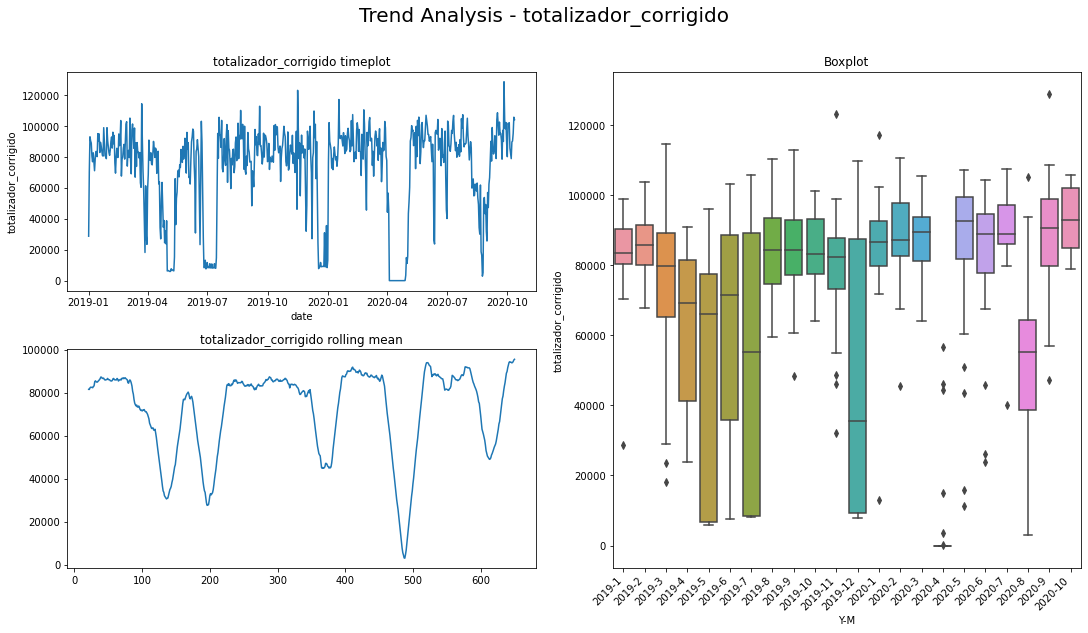

In [6]:
#- COMGAS 
trend_plots(comgas[['date', 'totalizador_corrigido']],
            series='totalizador_corrigido', s='Y-M',
            fig_size=(15,8))

ts_dict = {c : ['date',c] \
 for c in df.columns.values if 'gas' in c \
 and c not in ['gas_aci_fea', 'gas_aci_mlc', 'gas_uti_aci', 'total_comgas']}

#for k,v in ts_dict.items():
#    trend_plots(df[v], series=v[1], fig_size=(15,6))


Fig = go.Figure()

Fig.add_trace(go.Scatter(
    x=comgas.date,
    y=comgas.totalizador_corrigido))

### Seasonality

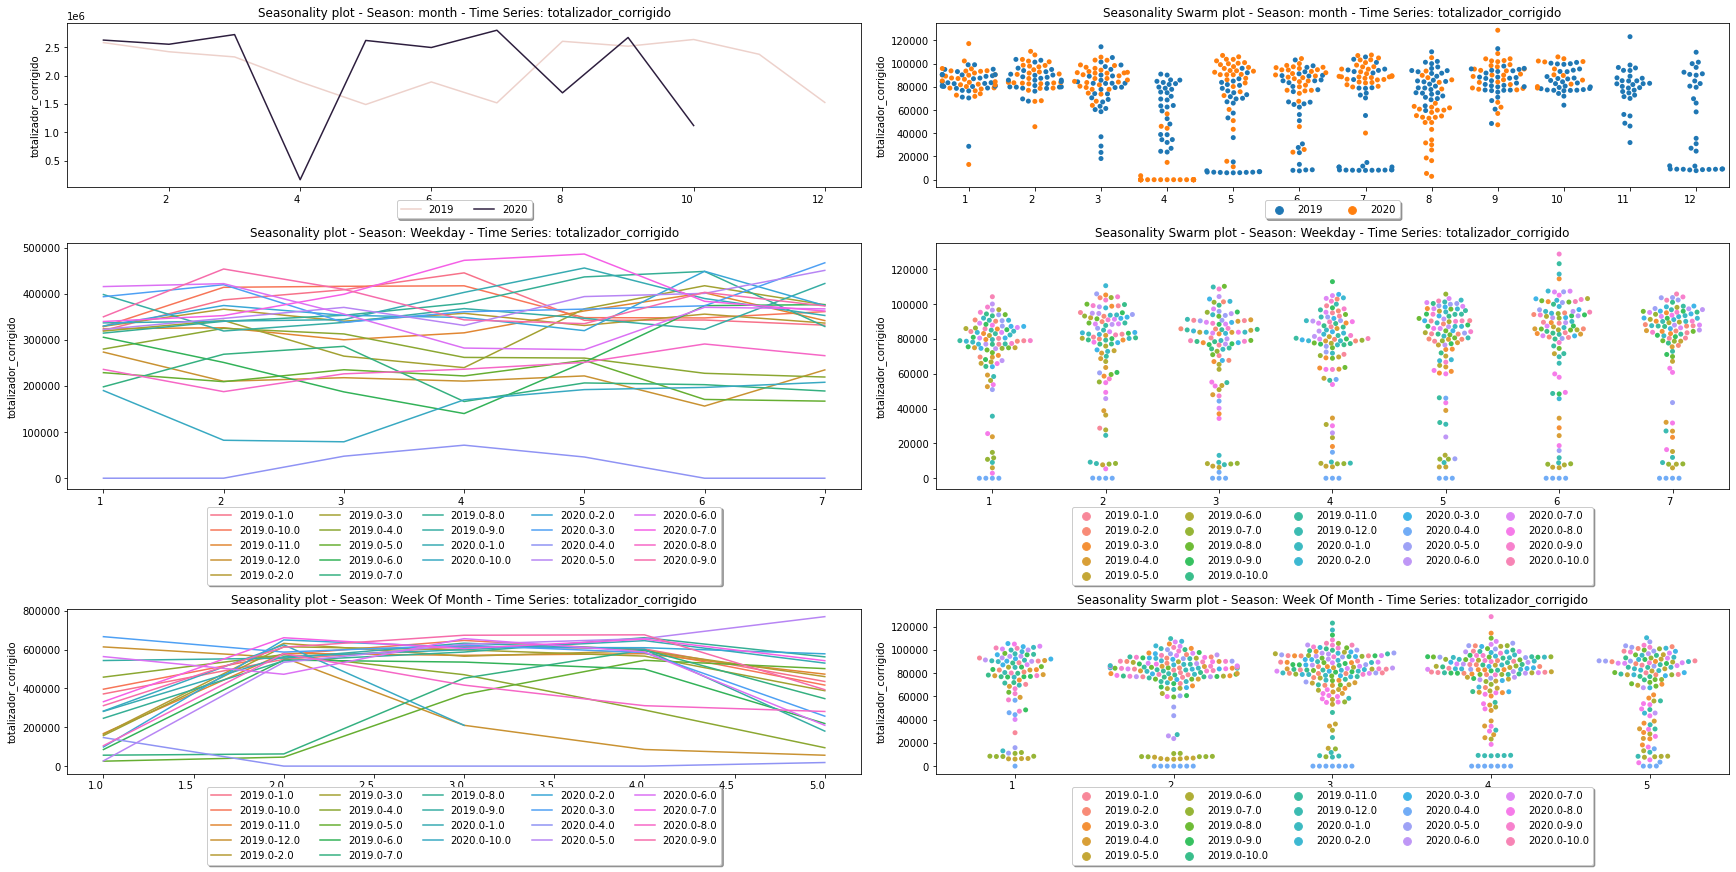

In [7]:
seasonality_plots(comgas[['date', 'totalizador_corrigido']],
               series='totalizador_corrigido', )

### Tt e St: RESULTADOS

**TREND**
- O patamar da série (Level) é constante;
- Não há tendência de alta ou baixa;
- Pontos de Atenção:
    * 2019-3 a 2019-7: 
        i) A partir de março/2019 há uma queda no consumo que se manteve até julho/2019;
        ii) Neste período a volatilidade (variância) da série aumenta, o que pode ser observado pela heterogeneidade das distribuições para os meses citados.
        * 2019-12: Parada da usina (Manutenção ou férias coletivas??)
        * 2020-04: COVDID-19
        * 2020-08: Parada da usina - manutenção
        

* **Seasonality**
    - Os plots de sazonalidade não apresentam nenhum padrão claro de sazonalidade;
    - Analisando o seasonality plot para s=Semana (WoM), aparentemente existe um maior consumo nas semanas 2 a 4 dos meses. No entanto, ao analisar o swarmplot para o mesmo s, o mesmo padrão sazonal não fica claro. O seasonality plot pode ter sofrido interferência do número de ocorrências para a primeira semana do mês, menor que para as demais. Da mesma forma para a semana 5 (ocorre com menor frequência nos meses) há um menor consumo agregado. 

## Series Decomposition



* Time Series can be modeled considering four components. Three of these components are systematic (Trend, Seasonality and Level) and one non-systematic component (noise)

* There are different techinques to decompose a time series. The naive approach considers wheter the time series is Multiplicative or Aditive.

* For the presented analysis the time series are modeled as additive, therefore:
    * yt = Lt + Tt + St + noise.

* (Additive models are linear and the model used here is linear (ARIMA))

REFS: 
- Shumeli et al., Pratical Time Series Forecasting with R (Section 2.2 - Time Series Components);
- Athanasopoulos, Forecasting Principals and Practice (Ch. 6.3)
- https://github.com/danielfaioli/priceforecast/blob/master/notebooks/eda_oil_cooper_imf.ipynb


**classical/naive decomposition**

1. Tt = 2*m-MA, m é par; Tt = m-MA, cc
2. detrendTt = yt-Tt
3. St=mean(detrendTt)
4. noise=yt-Tt-St

**Seasonal Decomposition using LOESS**

- https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html
- http://www.gardner.fyi/blog/STL-Part-I/ http://www.gardner.fyi/blog/STL-Part-II/
- http://www.gardner.fyi/blog/STL-Part-II/

In [8]:
def ts_decompose(ts, method='STL', **kwargs):
    
    robust = kwargs.get('robust', False)
    period = kwargs.get('period', 7)
    
    decompose_model = kwargs.get('decompose_model', 'additive')
    
    weights = kwargs.get('weights', True)
       
    def naive_decompose(ts, model='additive'):
        
        dec = seasonal_decompose(ts, model)
        
        return dec
    
    def stl_decompose(ts, robust=False, period=7):
        
        print(robust, period)
        dec = STL(ts, robust, period)
        dec = dec.fit()
        
        return dec
    
    if method=='STL':
        dec = stl_decompose(ts, robust=robust, period=period)
    elif method=='naive':
        dec = naive_decompose(ts, decompose_model)
    else:
        print(f'method {method} does not exist')
        
    dec.plot(weights=weights)
    plt.rc("figure", figsize=(12,12))
    plt.show();
        
    return dec

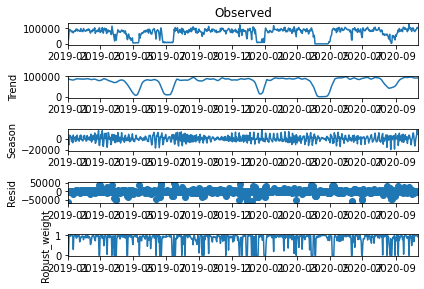

In [9]:
# PERIOD = 7 

period = 7
robust = True

stl_dec = STL(comgas[['date', 'totalizador_corrigido']].set_index('date').asfreq('D'),
                 robust=robust, period=period, seasonal=7).fit()

stl_dec.plot(weights=True)

plt.rc("figure", figsize=(12,12))
plt.show()


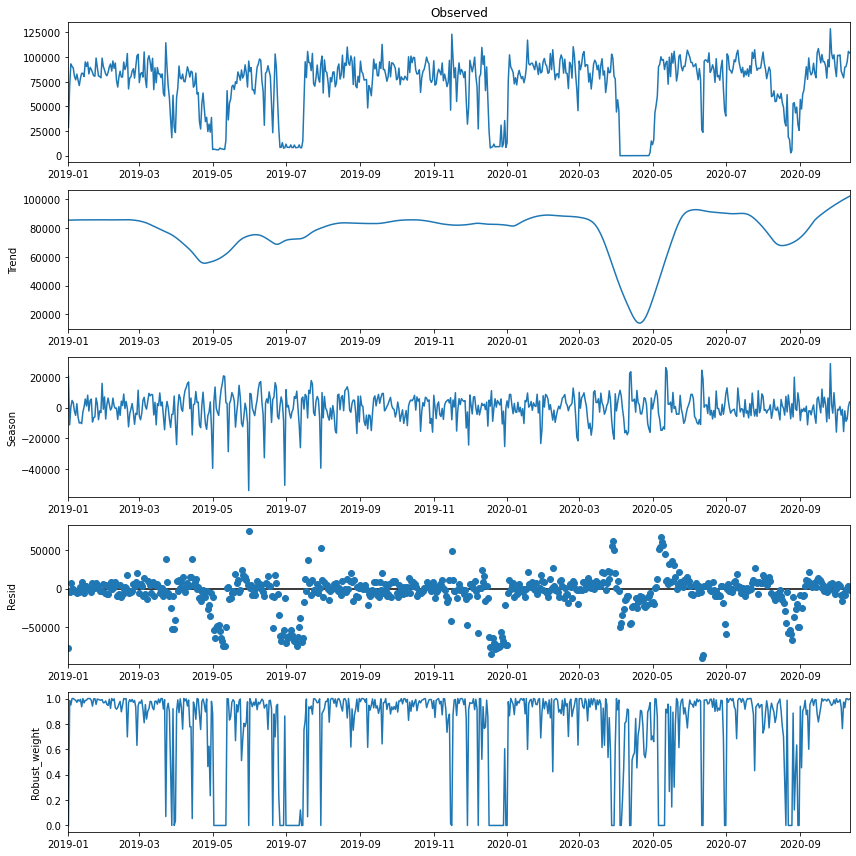

In [10]:
# Period = Month (30)

period = 30
robust = True

comgas_stl = STL(comgas[['date', 'totalizador_corrigido']].set_index('date').asfreq('D'),
                 robust=robust, period=period).fit()

comgas_stl.plot(weights=True)

plt.rc("figure", figsize=(12,12))
plt.show()


### Seasonal Adjusted Tests

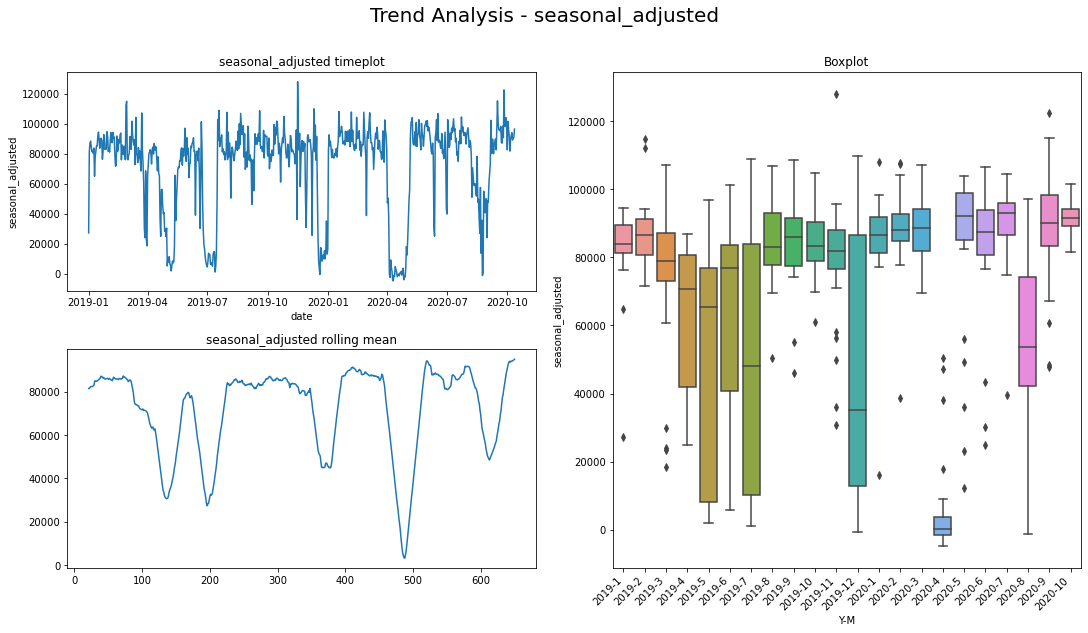

In [11]:
seasonal_adjusted = pd.DataFrame(
    comgas.set_index('date').totalizador_corrigido - stl_dec.seasonal,
    columns=['seasonal_adjusted']).reset_index()


trend_plots(seasonal_adjusted,
            series='seasonal_adjusted', s='Y-M',
            fig_size=(15,8))

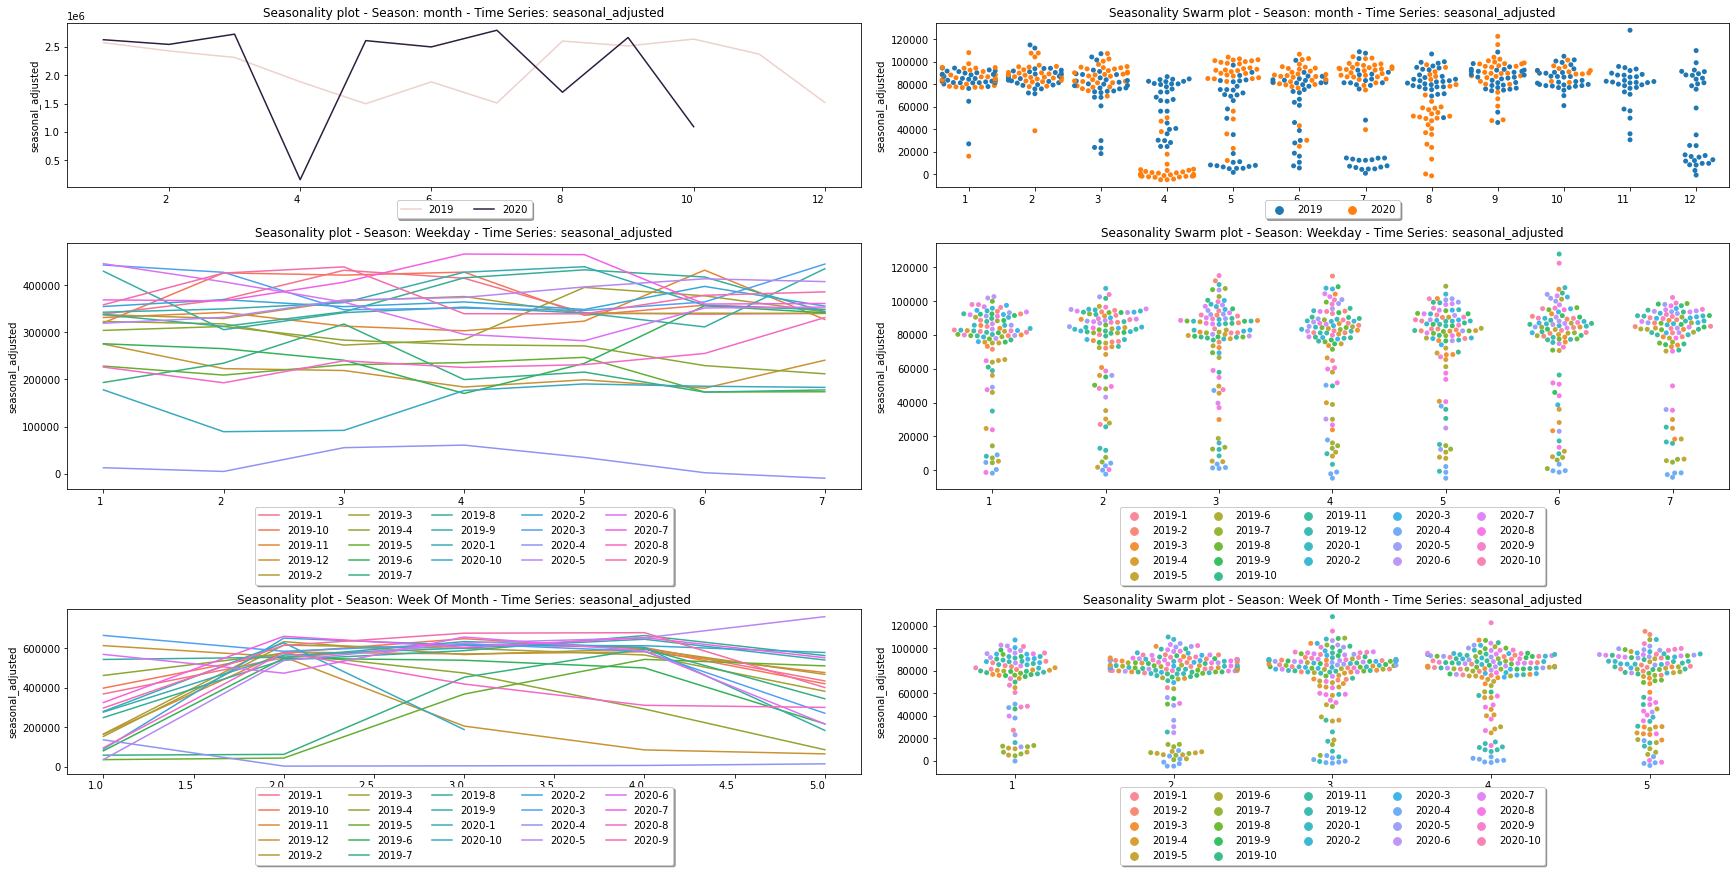

In [12]:
seasonality_plots(seasonal_adjusted, series='seasonal_adjusted')

## Testes de Estacionariedade

### ADF e KPSS

**Augmented Dickey Fuller Test - Testing For a Unit Root**

* A hipótese nula do ADF test é que existe uma raiz unitária (unit root), a hipótese alternativa é a não existência de uma raiz unitária.
    * Se: O valor da estatística do teste é maior que o valores críticos (pvalue greater than the critical size), então a hipótese nula não pode ser rejeitada, i.e, não pode-se rejeitar a hipótese que existe uma raiz unitária.

    * Se a hipótese nula não pode ser rejeita, isto é, existe uma raiz unitária, a série deve ser diferenciada para eliminação da raiz unitária i.e a série não é estacionária

**KPSS - Trend-Stationary Testing**

* A hipotése nula do Teste KPSS é que a série é estacionária. A hipótese alternativa é que a série não é estacionária.

* Deve-se buscar por evidências para não rejeitar a hipótese nula:
    * pvalues próximos a 0;
    * a estatística do teste é maior que os valores críticos.


In [13]:
def stationary_test(series, test=None):
    def _adf(series, method='AIC'):
        adf_t = adfuller(series, autolag=method)
        
        result = {
            'test_statistic': adf_t[0],
            'pvalue': adf_t[1]
        }
        
        
        for k, v in adf_t[4].items():
            k = str(100 - int(k.replace('%',''))) + "%"
            result[f'Critical Value {k}'] = v
                
        return result
    
    def _kpss(series, regression='c'):
        kpss_t = kpss(series, regression=regression, nlags='auto')
        
        result = {
            'test_statistic': kpss_t[0],
            'pvalue': kpss_t[1],
            'lags': kpss_t[2]
        }
        
        #cv_dict = {}
        
        for k, v in kpss_t[3].items():
            k = str(int(100 - float(k.replace('%','')))) + "%"
            result[f'Critical Value {k}'] = v
        
        return result        
    
    if test == 'ADF':
        return _adf(series)
    elif test == 'KPSS':
        return _kpss(series)
    elif test == 'both':
        adf_t = _adf(series)
        kpss_t = _kpss(series)
        return {'ADF': adf_t, 'KPSS': kpss_t}
    else:
        print(f'test {test} is no available')

In [14]:
comgas_stats = stationary_test(comgas.set_index('date').totalizador_corrigido, 'both')

adf_ = pd.DataFrame(comgas_stats['ADF'], index=['ADF'])
kpss_ = pd.DataFrame(comgas_stats['KPSS'], index=['KPSS'])

pd.concat([adf_, kpss_])


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




test_statistic    pvalue  Critical Value 99%  Critical Value 95%  \
ADF        -4.988293  0.000023           -3.440482           -2.866011   
KPSS        0.076100  0.100000            0.739000            0.463000   

      Critical Value 90%  lags  Critical Value 97%  
ADF            -2.569151   NaN                 NaN  
KPSS            0.347000  16.0               0.574

Confidence interval: [0.07681845656362281, -0.07681845656362281]


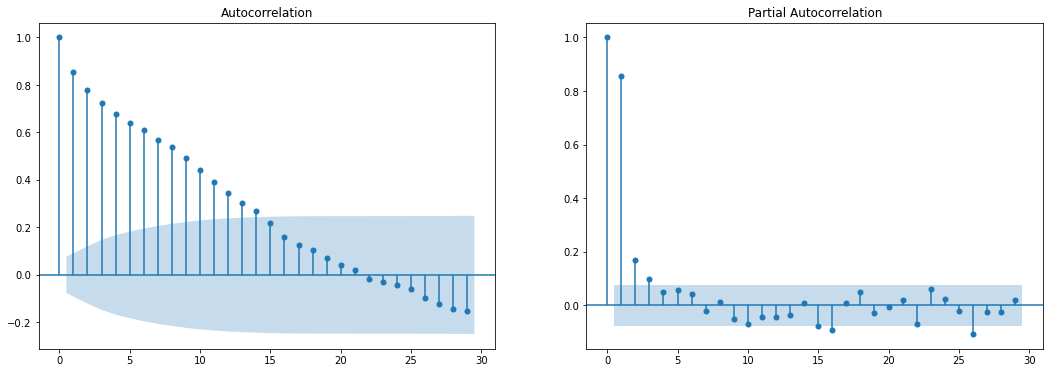

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts_comgas = comgas.set_index('date').totalizador_corrigido

ts_log = np.log(ts_comgas)

fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(18,6))

ci = [c*(1.96 / np.sqrt(len(ts_comgas))) for c in [1, -1]]

print(f"Confidence interval: {ci}")

plot_acf(comgas.set_index('date').totalizador_corrigido, ax=ax1)

plot_pacf(comgas.set_index('date').totalizador_corrigido, ax=ax2)

plt.show()


In [16]:
np.log( comgas.set_index('date').totalizador_corrigido)

date
2019-01-01    10.266949
2019-01-02    11.162531
2019-01-03    11.441977
2019-01-04    11.413437
2019-01-05    11.397144
                ...    
2020-10-08    11.405396
2020-10-09    11.411911
2020-10-10    11.465981
2020-10-11    11.569684
2020-10-12    11.554758
Name: totalizador_corrigido, Length: 651, dtype: float64

Confidence interval: [0.07681845656362281, -0.07681845656362281]


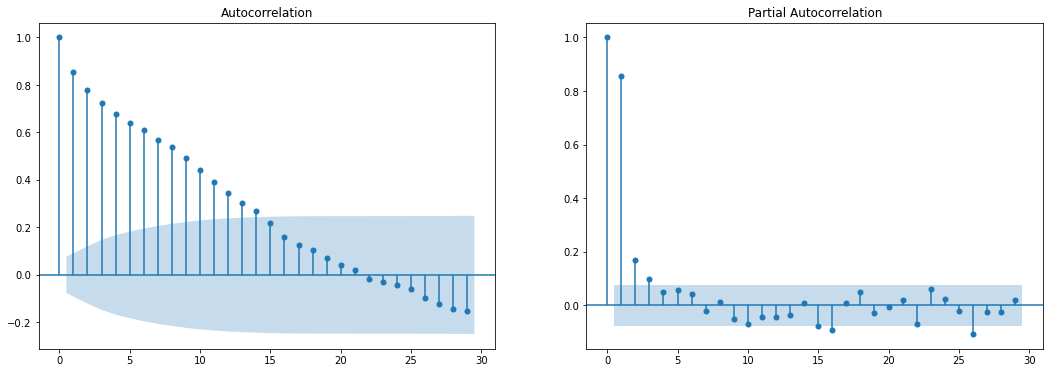

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts_comgas = comgas.set_index('date').totalizador_corrigido # .diff().dropna()

ts_log = np.log(comgas.set_index('date').totalizador_corrigido)

fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(18,6))

ci = [c*(1.96 / np.sqrt(len(ts_comgas))) for c in [1, -1]]

print(f"Confidence interval: {ci}")

plot_acf(ts_comgas, ax=ax1)

plot_pacf(ts_comgas, ax=ax2)

plt.show()


# Model Building - ARIMA(p,0,q)

**Assumptions**

- Série é estacionária (d=0)
- Autorregresive Process of order p=4
- True Model ARIMA(4,0,0)

In [18]:
def mae(residuals):
    return np.mean(np.abs(residuals))

def mape(real, proj):
    ape = np.abs(real-proj)/np.abs(real)
    ape[ape == np.inf] = 0 
    ape = np.nan_to_num(ape, nan=0)
        
    mape = np.mean(ape)*100 #MAPE
    
    return mape

In [113]:
%%time
from statsmodels.tsa.arima.model import ARIMA

ts = comgas.set_index('date').totalizador_corrigido.asfreq('D')

p_order = 4
q_order = 4
d = 0

model_selection = []

aic_matrix = []
bic_matrix = []

for p in range(p_order+1):
    aic_tmp = []
    bic_tmp = []
    
    for q in range(q_order+1):
        model = ARIMA(ts, order=(p, d, q))
        results = model.fit()
        model_selection.append((p,q, results.aic, results.bic))
        aic_tmp.append(results.aic)
        bic_tmp.append(results.bic)
        
    aic_matrix.append(aic_tmp)
    bic_matrix.append(bic_tmp)

aic_matrix = np.matrix(aic_matrix).reshape(p_order+1,q_order+1)
bic_matrix = np.matrix(bic_matrix).reshape(p_order+1,q_order+1)
model_selection = pd.DataFrame(model_selection, columns=['p','q', 'aic', 'bic'])

print("AIC")
print(f"Minimum AIC: {aic_matrix.min()}")
display(pd.DataFrame(aic_matrix))


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AIC
Minimum AIC: 14373.315338343


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0             1             2             3             4
0  18829.318852  14908.868499  14789.631297  14717.461445  14671.903757
1  14395.109455  14375.177170  14373.758149  14375.334072  14377.057351
2  14379.238153  14373.315338  14375.295799  14377.257565  14379.015097
3  14376.158528  14375.301158  14377.305383  14379.274800  14379.273709
4  14376.863885  14377.217940  14379.245996  14375.014222  14380.605083

Wall time: 20 s


In [20]:
print("BIC")
print(f"Minimum BIC: {bic_matrix.min()}")
display(pd.DataFrame(bic_matrix))

BIC
Minimum BIC: 14393.09120826497


0             1             2             3             4
0  18838.275871  14922.304028  14807.545336  14739.853993  14698.774815
1  14408.544984  14393.091208  14396.150697  14402.205129  14408.406919
2  14397.152192  14395.707887  14402.166857  14408.607132  14414.843175
3  14398.551076  14402.172216  14408.654951  14415.102878  14419.580296
4  14403.734943  14408.567508  14415.074073  14415.320809  14425.390179

In [21]:
print(f"Minimum AIC: {model_selection.aic.min()}")
print(f"Minimum BIC: {model_selection.bic.min()}")

print(model_selection.loc[model_selection.aic==model_selection.aic.min()])
print(model_selection.loc[model_selection.bic==model_selection.bic.min()])

Minimum AIC: 14373.315338343
Minimum BIC: 14393.09120826497
    p  q           aic           bic
11  2  1  14373.315338  14395.707887
   p  q          aic           bic
6  1  1  14375.17717  14393.091208


## MODEL DIAGNOSTICS

**BASED ON AIC AND BIC**

* Possible Models: 
    - AIC: ARIMA(2,0,1)
    - BIC: ARIMA(1,0,1)
 


In [22]:
%%time

model_201 = ARIMA(ts.asfreq('D'), order=(1,0,2))
results_201 = model_201.fit()

model_101 = ARIMA(ts.asfreq('D'), order=(4,0,4))
results_101 = model_101.fit()

def mae(residuals):
    return np.mean(np.abs(residuals))

print(f"ARIMA(2,0,1) MAE: {mae(results_201.resid)}")
print(f"ARIMA(1,0,1) MAE: {mae(results_101.resid)}")

ARIMA(2,0,1) MAE: 10821.628435614844
ARIMA(1,0,1) MAE: 10853.352919196042
Wall time: 3.88 s


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



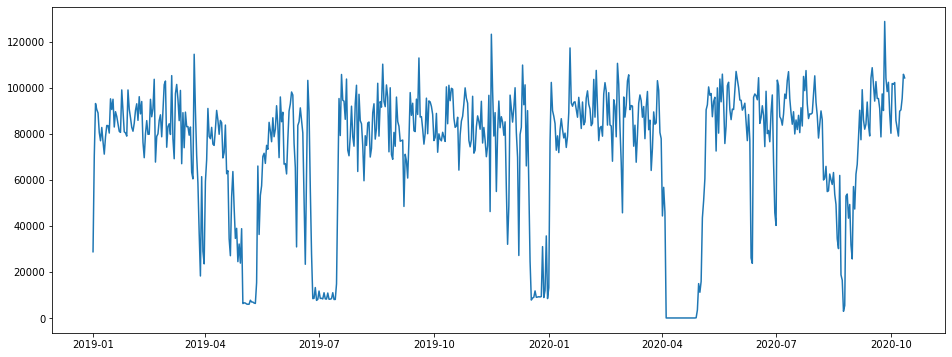

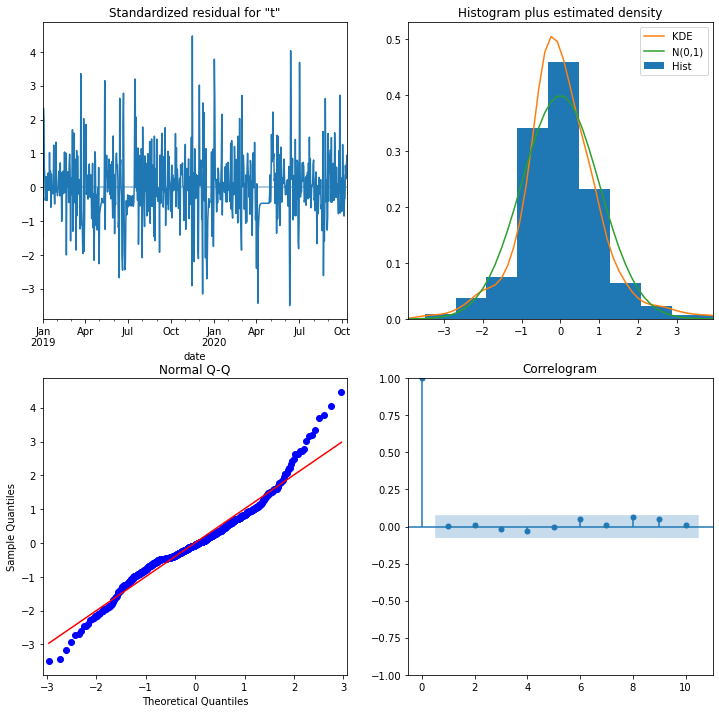

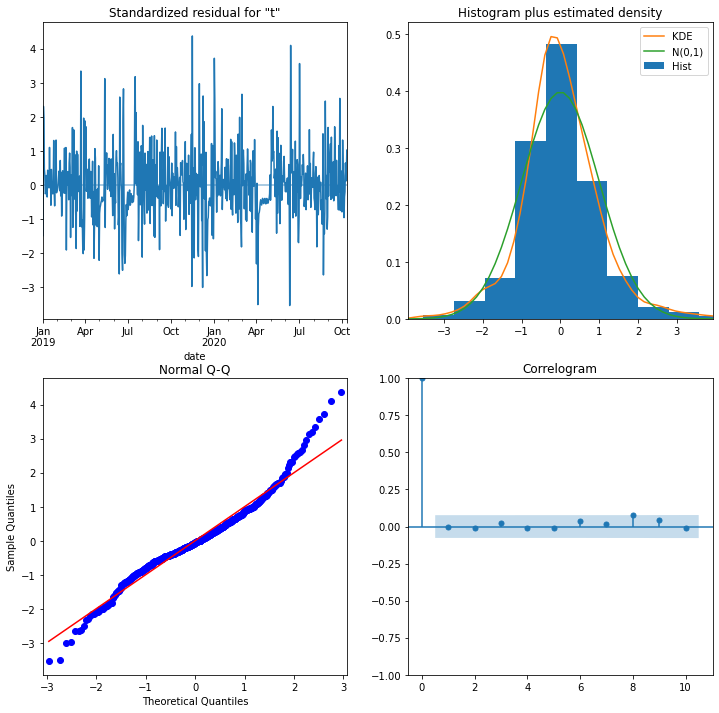

In [23]:
fig = plt.figure(figsize=(16,6))

plt.plot(ts)

results_201.plot_diagnostics()

results_101.plot_diagnostics()

plt.show()

10821.628435614844
                                 SARIMAX Results                                 
Dep. Variable:     totalizador_corrigido   No. Observations:                  651
Model:                    ARIMA(1, 0, 2)   Log Likelihood               -7181.879
Date:                   Tue, 19 Jan 2021   AIC                          14373.758
Time:                           20:52:17   BIC                          14396.151
Sample:                       01-01-2019   HQIC                         14382.443
                            - 10-12-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.251e+04   6166.740     11.759      0.000    6.04e+04    8.46e+04
ar.L1          0.9339      0.019     49.407      0.000       0.897       0.971
ma.L1    

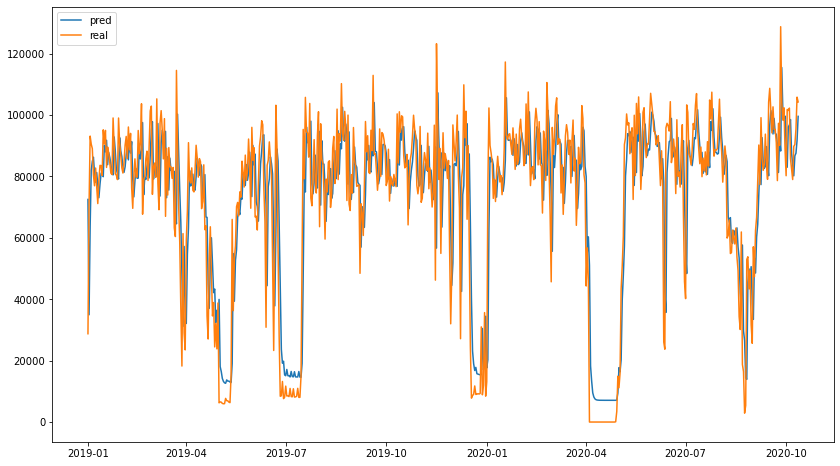

In [24]:
fig = plt.figure(figsize=(14,8))

predict = results_201.predict()

residuals = ts - predict

print(mae(residuals))

print(results_201.summary())

plt.plot(results_201.predict(start='2019-01-01').index, results_201.predict(start='2019-01-01'), label='pred')
plt.plot(ts.index, ts, label='real')
plt.legend(loc='best')
plt.show()

                                 SARIMAX Results                                 
Dep. Variable:     totalizador_corrigido   No. Observations:                  651
Model:                    ARIMA(4, 0, 4)   Log Likelihood               -7180.303
Date:                   Tue, 19 Jan 2021   AIC                          14380.605
Time:                           20:52:18   BIC                          14425.390
Sample:                       01-01-2019   HQIC                         14397.975
                            - 10-12-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.251e+04   6341.235     11.435      0.000    6.01e+04    8.49e+04
ar.L1          1.7051      0.555      3.072      0.002       0.617       2.793
ar.L2         -1.8319      0

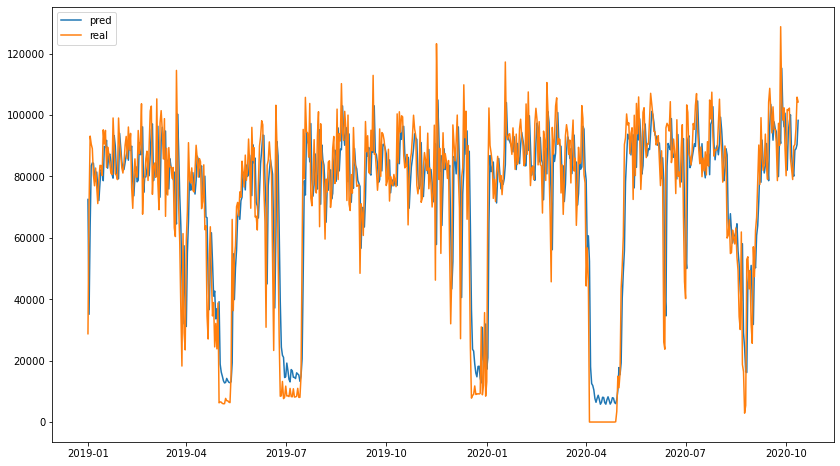

In [25]:
fig = plt.figure(figsize=(14,8))

predict = results_101.predict()

residuals = ts - predict

print(results_101.summary())

print(mae(residuals))

plt.plot(predict.index, predict, label='pred')
plt.plot(ts.index, ts, label='real')
plt.legend(loc='best')
plt.show()

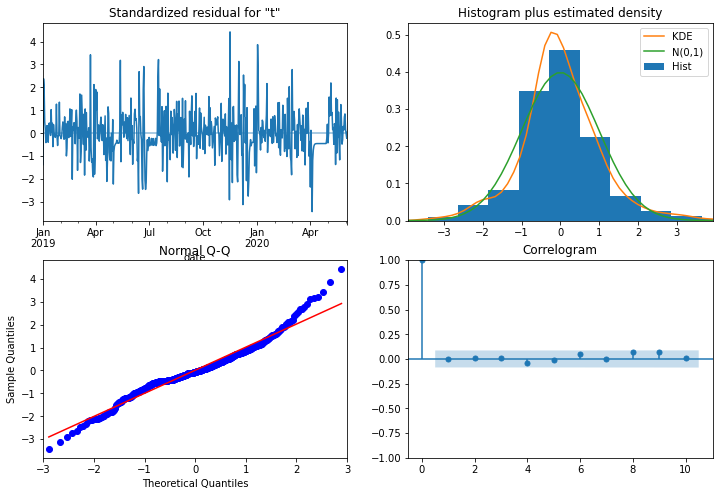

In [26]:
hist = comgas.set_index('date').totalizador_corrigido.asfreq('D')

#hist = hist[dt.date(2019,8,1):dt.date(2019,12,1)]

size = int(len(hist)*0.8)

train = hist[:size]
test = hist[size:]

order = (2,0,1)

model = ARIMA(train, order=order)
result = model.fit()

#print(f"ARIMA{order} MAE: {mae(result.resid)}")

result.plot_diagnostics(figsize=(12,8))
plt.show()

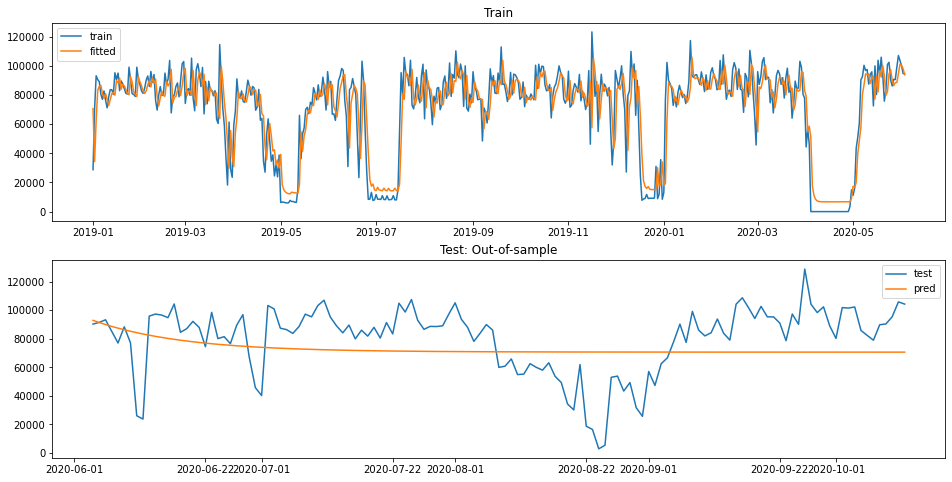

In [27]:
pred = result.predict(start=test.index[0], end=test.index[-1], dynamic=True)


fig, axs = plt.subplots(2,1,figsize=(16,8))

axs[0].plot(train, label='train')
axs[0].plot(result.fittedvalues, label='fitted')
axs[0].legend(loc='best')

axs[0].set_title('Train')

axs[1].plot(test, label='test')
axs[1].plot(pred, label='pred')
axs[1].legend(loc='best')

axs[1].set_title('Test: Out-of-sample')

plt.show()

ARIMA(2, 0, 1): predicted=92876.771239, expected=90279.000000
ARIMA(2, 0, 1): predicted=89569.077315, expected=91471.000000
ARIMA(2, 0, 1): predicted=89704.043446, expected=93291.000000
ARIMA(2, 0, 1): predicted=90847.225036, expected=85136.000000
ARIMA(2, 0, 1): predicted=85402.161967, expected=77029.000000
ARIMA(2, 0, 1): predicted=78817.170073, expected=88366.000000
ARIMA(2, 0, 1): predicted=85219.238957, expected=77089.000000
ARIMA(2, 0, 1): predicted=78332.298537, expected=26050.000000
ARIMA(2, 0, 1): predicted=41866.934674, expected=23720.000000
ARIMA(2, 0, 1): predicted=33091.705501, expected=95835.000000
ARIMA(2, 0, 1): predicted=81034.844129, expected=97310.000000
ARIMA(2, 0, 1): predicted=88522.030260, expected=96574.000000
ARIMA(2, 0, 1): predicted=91116.703683, expected=94785.000000
ARIMA(2, 0, 1): predicted=91353.676373, expected=104370.000000
ARIMA(2, 0, 1): predicted=98664.251894, expected=84519.000000
ARIMA(2, 0, 1): predicted=85998.272301, expected=87050.000000
ARIMA(2

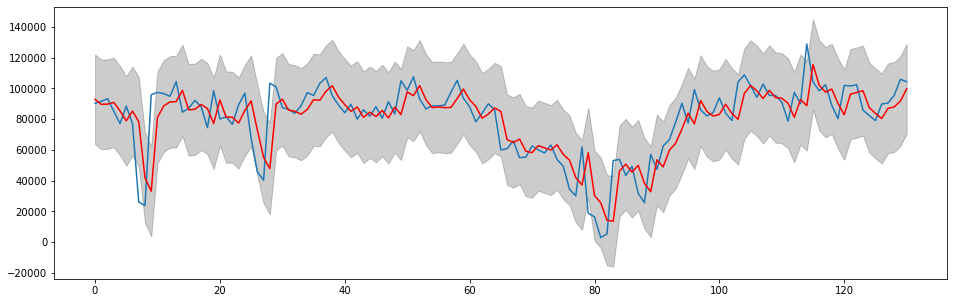

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math 
predictions = list()
pred_ci = list()

history = [x for x in train]

for t in range(len(test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.get_forecast()
    yhat = output.predicted_mean[0]
    l_ci = output.conf_int()[0][0]
    u_ci = output.conf_int()[0][1]
    pred_ci.append((l_ci,u_ci))
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('ARIMA%s: predicted=%f, expected=%f' % (order, yhat, obs))

pred_ci = pd.DataFrame(pred_ci, columns=['l_ci','u_ci'])
    
mse = mean_squared_error(test, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)

print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

# plot
fig,axs =  plt.subplots(ncols=1, nrows=1, figsize=(16, 5))

axs.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()

In [29]:
def mape(real, proj):
    ape = np.abs(real-proj)/np.abs(real)
    ape[ape == np.inf] = 0 
    ape = np.nan_to_num(ape, nan=0)
        
    mape = np.mean(ape)*100 #MAPE
    
    return mape

mape(test.values, predictions)

24.137875387316353

Confidence interval: [0.07681845656362281, -0.07681845656362281]


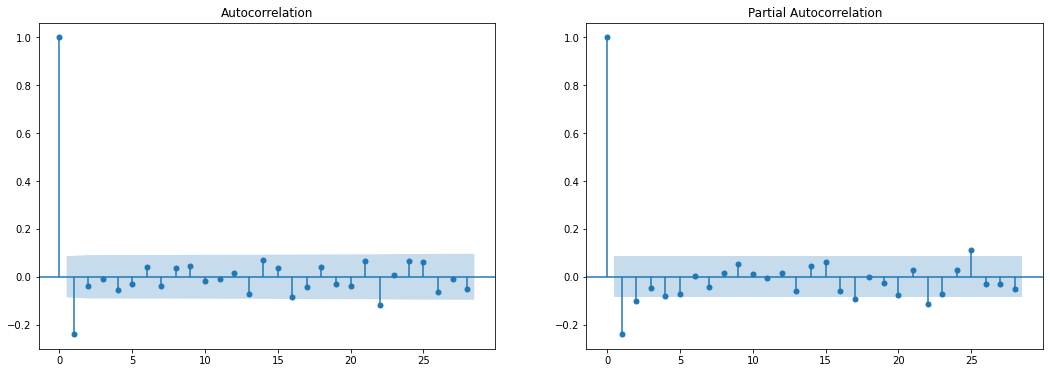

In [56]:
hist = comgas.set_index('date').totalizador_corrigido.diff().dropna().asfreq('D')

size = int(len(hist)*0.8)

train = hist[:size]
test = hist[size:]

fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(18,6))

ci = [c*(1.96 / np.sqrt(len(ts_comgas))) for c in [1, -1]]

print(f"Confidence interval: {ci}")

plot_acf(train, ax=ax1)

plot_pacf(train, ax=ax2)

plt.show()

In [206]:
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math 

from statsmodels.tsa.statespace.sarimax import SARIMAX

def mae(residuals):
    return np.mean(np.abs(residuals))

def gridsearch_ARIMA(ts, order, verbose=False):
    """
    This is a helper function to gridsearch
    ARIMA model parameters
    """
    p,d,q = order

    classes = list(itertools.product(range(p+1), range(d+1), range(q+1)))
    
    model_selection = []
    
    for param in classes:
        try:
            model = ARIMA(ts, order=param).fit()
            results = (param, model.aic, model.bic, mae(model.resid))
            model_selection.append(results)  
            if verbose:
                print(f"ARIMA{param} - AIC:{model.aic} BIC:{model.bic} MAE:{mae(model.resid)}")          
        except:
            continue

    model_selection = pd.DataFrame(model_selection,
                                   columns = ['order', 'aic', 'bic', 'mae'])
    
    
    return model_selection

def gridsearch_SARIMAX(ts, order, seasonal_step=30, verbose=False):
    """
    This is a helper function to gridsearch
    SARIMA model parameters
    """
    p,d,q = order
    
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_step)
                    for x in list(itertools.product(range(p+1), range(d+1), range(q+1)))]
    
    classes = list(itertools.product(range(p+1), range(d+1), range(q+1)))
    
    model_selection = []
    
    for param in classes:
        for param_season in seasonal_pdq:
#            try:
            model = SARIMAX(ts, order=param, seasonal_order=param_season).fit()
            results = (param, model.aic, model.bic, mae(model.resid))
            model_selection.append(results)  
            if verbose:
                print(f"SARIMA{param} - AIC:{model.aic} BIC:{model.bic} MAE:{mae(model.resid)}")          
#            except:
#                continue

    model_selection = pd.DataFrame(model_selection,
                                   columns = ['order', 'aic', 'bic', 'mae'])
    
    
    return model_selection

def one_step_forecast(train, test, order, verbose=False):

    predictions = list()
    pred_ci = list()

    history = [x for x in train]

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.get_forecast()
        yhat = output.predicted_mean[0]
        l_ci = output.conf_int()[0][0]
        u_ci = output.conf_int()[0][1]
        pred_ci.append((l_ci,u_ci))
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        
        if verbose:
            print('ARIMA%s: predicted=%f, expected=%f' % (order, yhat, obs))

    pred_ci = pd.DataFrame(pred_ci, columns=['l_ci','u_ci'])

    mse = mean_squared_error(test, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(test, predictions)
    r2 = r2_score(test, predictions)

    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: %.3f' % mae)
    print('Test R2: %.3f' % r2)
    
    return predictions, pred_ci


In [160]:
hist = comgas.set_index('date').totalizador_corrigido.asfreq('D')

size = int(len(hist)*0.8)

train = hist[:size]
test = hist[size:]

order = (3,1,3)

grd_res = gridsearch_ARIMA(train, order)

ARIMA(0, 0, 0) - AIC:14962.85545393765 BIC:14971.3631115608 MAE:23974.53653846154
ARIMA(0, 0, 1) - AIC:11948.666094846627 BIC:11961.427581281354 MAE:17353.451364053308
ARIMA(0, 0, 2) - AIC:11849.625553216789 BIC:11866.640868463091 MAE:15057.202409217016
ARIMA(0, 0, 3) - AIC:11783.88885993428 BIC:11805.158003992157 MAE:13762.185401082279
ARIMA(0, 1, 0) - AIC:11511.073920253933 BIC:11515.325824137099 MAE:11054.053846153845
ARIMA(0, 1, 1) - AIC:11480.290251837776 BIC:11488.794059604108 MAE:10583.350708098591
ARIMA(0, 1, 2) - AIC:11480.058777899496 BIC:11492.814489548993 MAE:10559.074220159311
ARIMA(0, 1, 3) - AIC:11480.773959202554 BIC:11497.781574735218 MAE:10587.413779518638
ARIMA(1, 0, 0) - AIC:11503.500181483385 BIC:11516.261667918112 MAE:11339.568544242145
ARIMA(1, 0, 1) - AIC:11484.707881413855 BIC:11501.723196660158 MAE:10897.940318641482
ARIMA(1, 0, 2) - AIC:11486.243325612935 BIC:11507.512469670812 MAE:10874.979783125189
ARIMA(1, 0, 3) - AIC:11488.128643069957 BIC:11513.651615939

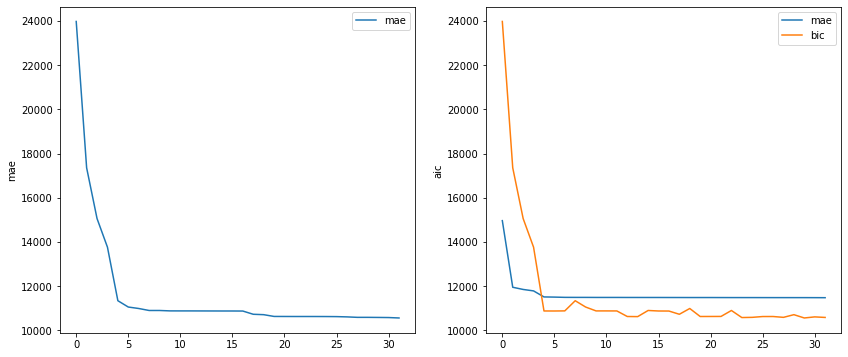

order           aic           bic           mae
22  (2, 1, 3)  11483.879377  11509.390801  10625.717907
23  (2, 1, 1)  11479.837117  11496.844732  10625.313131
24  (1, 1, 2)  11479.951925  11496.959540  10623.932503
25  (3, 1, 2)  11483.840584  11509.352008  10620.560203
26  (1, 1, 1)  11478.657629  11491.413341  10608.222883
27  (0, 1, 3)  11480.773959  11497.781575  10587.413780
28  (2, 1, 0)  11482.846627  11495.602339  10587.188073
29  (0, 1, 1)  11480.290252  11488.794060  10583.350708
30  (3, 1, 0)  11483.798663  11500.806278  10578.372882
31  (0, 1, 2)  11480.058778  11492.814490  10559.074220

In [158]:
fig,axs = plt.subplots(1,2,figsize=(14,6))

sns.lineplot(
    data=grd_res.sort_values('mae', ascending=False).reset_index(drop=True),
    x=grd_res.sort_values('mae', ascending=False).reset_index(drop=True).index,
    y='mae',
    label='mae', ax=axs[0])

sns.lineplot(
    data=grd_res.sort_values('aic', ascending=False).reset_index(drop=True),
    x=grd_res.sort_values('aic', ascending=False).reset_index(drop=True).index,
    y='aic',
    label='mae', ax=axs[1])

sns.lineplot(
    data=grd_res.sort_values('bic', ascending=False).reset_index(drop=True),
    x=grd_res.sort_values('bic', ascending=False).reset_index(drop=True).index,
    y='mae',
    label='bic', ax=axs[1])

plt.show()

grd_res.sort_values(['mae'], ascending=False).reset_index(drop=True).tail(10)


Test MSE: 226560920.736
Test RMSE: 15051.941
Test MAE: 10544.385
Test R2: 0.584


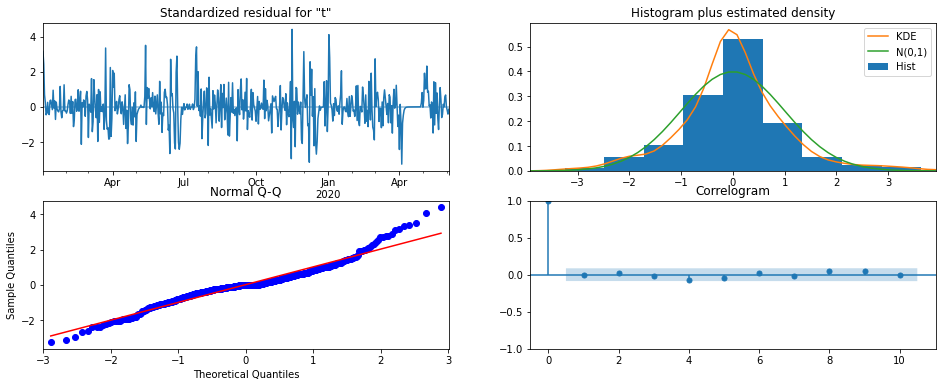

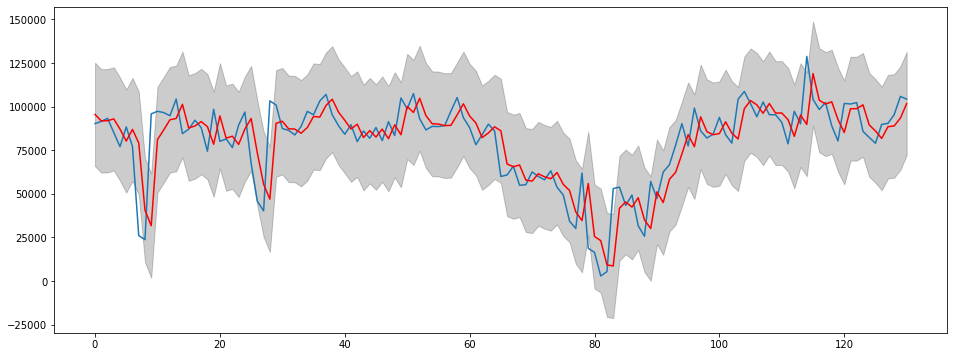

In [165]:
order=(0,1,2)

model = ARIMA(train, order=order)
result = model.fit()

result.plot_diagnostics(figsize=(16,6))

predictions, pred_ci = one_step_forecast(train, test, order)

# plot
fig,axs =  plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

axs.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show() 

## IQR OUTLIER FILTERING

In [170]:
def iqr_filter(data):
    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    iqr = q3-q1
    
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    
    data = data[~((data < lower)|(data > upper))]
    
    return data

Confidence interval: [0.07681845656362281, -0.07681845656362281]


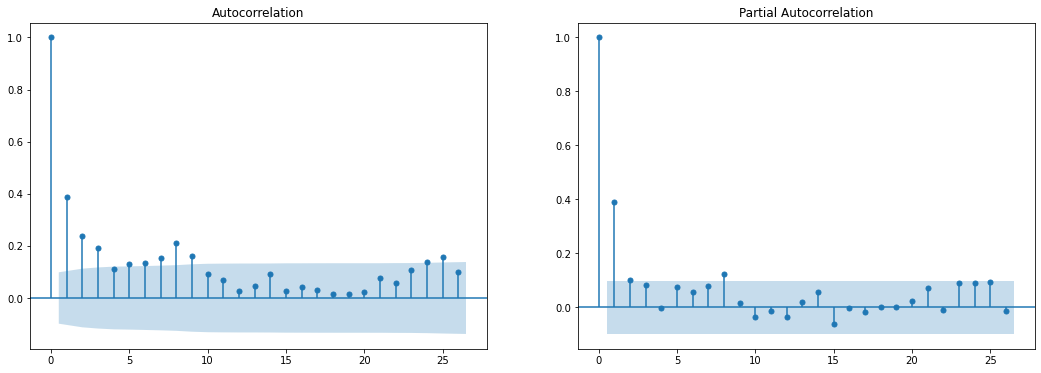

In [193]:

val_size = int(len(hist)*0.9)

hist1 = hist[:val_size]

validate = hist[val_size:]

hist1_filter_df = iqr_filter(hist1)
hist1_filter_s = hist1_filter_df.reset_index().totalizador_corrigido

size = int(len(hist1_filter_s)*0.8)

train = hist1_filter_s[:size]
test = hist1_filter_s[size:]

fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(18,6))

ci = [c*(1.96 / np.sqrt(len(ts_comgas))) for c in [1, -1]]

print(f"Confidence interval: {ci}")

plot_acf(train, ax=ax1)

plot_pacf(train, ax=ax2)

plt.show()


In [189]:
order = (10,1,10)

grd_res = gridsearch_ARIMA(train, order, True)

ARIMA(0, 0, 0) - AIC:12010.929006518345 BIC:12019.12065564321 MAE:10579.192090739387
ARIMA(0, 0, 1) - AIC:9679.319069007757 BIC:9691.606542695054 MAE:9616.312704818309
ARIMA(0, 0, 2) - AIC:9663.618298507885 BIC:9680.001596757615 MAE:9514.899591752492
ARIMA(0, 0, 3) - AIC:9653.534740004947 BIC:9674.013862817108 MAE:9311.583853028507
ARIMA(0, 0, 4) - AIC:9654.319466679211 BIC:9678.894414053804 MAE:9303.525166591515
ARIMA(0, 0, 5) - AIC:9654.890438550345 BIC:9683.56121048737 MAE:9280.716155296492
ARIMA(0, 0, 6) - AIC:9656.927362514209 BIC:9689.693959013666 MAE:9279.166184595242
ARIMA(0, 0, 7) - AIC:9658.895443671365 BIC:9695.757864733256 MAE:9282.449420887366
ARIMA(0, 0, 8) - AIC:9658.383395637728 BIC:9699.34164126205 MAE:9241.96098489887
ARIMA(0, 0, 9) - AIC:9656.919681055717 BIC:9701.97375124247 MAE:9209.311945086354
ARIMA(0, 0, 10) - AIC:9658.093911587728 BIC:9707.243806336915 MAE:9245.673687763634
ARIMA(0, 1, 0) - AIC:9774.193440870738 BIC:9778.287010640783 MAE:11220.993243243243
ARIM

D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 6) - AIC:9652.51655348558 BIC:9689.358681415986 MAE:9600.142637783269


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 7) - AIC:9654.370506792771 BIC:9695.306204493223 MAE:9536.56076526428
ARIMA(2, 1, 8) - AIC:9656.550458589501 BIC:9701.579726059997 MAE:9547.606906318275


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 9) - AIC:9656.660088458004 BIC:9705.782925698546 MAE:9563.339590227244
ARIMA(2, 1, 10) - AIC:9659.179912748052 BIC:9712.396319758638 MAE:9517.343972336266
ARIMA(3, 0, 0) - AIC:9649.340359521557 BIC:9669.819482333718 MAE:9255.798659860428
ARIMA(3, 0, 1) - AIC:9650.805830468675 BIC:9675.380777843267 MAE:9253.537852434602
ARIMA(3, 0, 2) - AIC:9652.818543436468 BIC:9681.489315373494 MAE:9252.482353527048
ARIMA(3, 0, 3) - AIC:9651.85735812605 BIC:9684.623954625507 MAE:9207.871506233465
ARIMA(3, 0, 4) - AIC:9652.72704834854 BIC:9689.589469410432 MAE:9205.595289984134
ARIMA(3, 0, 5) - AIC:9654.85670834436 BIC:9695.814953968682 MAE:9204.903460881776


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 0, 6) - AIC:9653.541151864369 BIC:9698.595222051123 MAE:9157.473297514563


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 0, 7) - AIC:9656.590642408624 BIC:9705.740537157812 MAE:9170.761563872702
ARIMA(3, 0, 8) - AIC:9657.233438664782 BIC:9710.4791579764 MAE:9208.221491634054
ARIMA(3, 0, 9) - AIC:9658.153524482697 BIC:9715.495068356748 MAE:9142.734748458111


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 0, 10) - AIC:9657.429814713523 BIC:9718.867183150007 MAE:9186.481269088796
ARIMA(3, 1, 0) - AIC:9697.717837861146 BIC:9714.092116941327 MAE:10177.398399011228
ARIMA(3, 1, 1) - AIC:9648.971805092322 BIC:9669.439653942547 MAE:9574.991378599309
ARIMA(3, 1, 2) - AIC:9648.521321287275 BIC:9673.082739907546 MAE:9557.66328447993
ARIMA(3, 1, 3) - AIC:9648.95824199274 BIC:9677.613230383055 MAE:9573.320071400236


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 4) - AIC:9648.720088894492 BIC:9681.468647054853 MAE:9492.453245269997


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 5) - AIC:9651.51147484827 BIC:9688.353602778676 MAE:9506.441095577104


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 6) - AIC:9654.262749990392 BIC:9695.198447690844 MAE:9616.496524560564


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 7) - AIC:9653.19437289749 BIC:9698.223640367985 MAE:9567.465954401969


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 8) - AIC:9655.218351643049 BIC:9704.34118888359 MAE:9567.51275507997


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 9) - AIC:9658.685896436946 BIC:9711.902303447532 MAE:9560.658603606147


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 10) - AIC:9657.02769688885 BIC:9714.337673669483 MAE:9563.606862818735
ARIMA(4, 0, 0) - AIC:9651.182320746062 BIC:9675.757268120655 MAE:9258.660546693553
ARIMA(4, 0, 1) - AIC:9652.808080616547 BIC:9681.478852553573 MAE:9253.258985942024


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 2) - AIC:9651.561583984432 BIC:9684.32818048389 MAE:9213.829989996631
ARIMA(4, 0, 3) - AIC:9651.170790684417 BIC:9688.033211746308 MAE:9170.859204255288


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 4) - AIC:9653.00519941008 BIC:9693.963445034402 MAE:9213.387663961694


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 5) - AIC:9654.812538101784 BIC:9699.866608288537 MAE:9200.089776257133


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 6) - AIC:9657.200708470515 BIC:9706.350603219702 MAE:9200.469606428518


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 7) - AIC:9655.96729816861 BIC:9709.21301748023 MAE:9184.298668599224
ARIMA(4, 0, 8) - AIC:9658.031600086104 BIC:9715.373143960154 MAE:9155.950704181976


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 9) - AIC:9658.078283786557 BIC:9719.51565222304 MAE:9212.334864047352


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 10) - AIC:9660.080420086717 BIC:9725.613613085632 MAE:9223.192077911886
ARIMA(4, 1, 0) - AIC:9686.497405092774 BIC:9706.965253942999 MAE:10073.778446966066
ARIMA(4, 1, 1) - AIC:9649.48534528917 BIC:9674.04676390944 MAE:9573.476784523573
ARIMA(4, 1, 2) - AIC:9650.787566373188 BIC:9679.442554763504 MAE:9559.648703371166


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 3) - AIC:9649.781831297987 BIC:9682.530389458349 MAE:9554.721794242949


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 4) - AIC:9649.04953648257 BIC:9685.891664412975 MAE:9484.068399923017
ARIMA(4, 1, 5) - AIC:9653.909375030347 BIC:9694.845072730799 MAE:9554.574566258436


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 6) - AIC:9654.044294942853 BIC:9699.073562413349 MAE:9488.337352877405


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 7) - AIC:9656.30820695555 BIC:9705.431044196092 MAE:9582.703259682039


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 8) - AIC:9657.892274364389 BIC:9711.108681374975 MAE:9563.746491365344


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 9) - AIC:9658.97455342449 BIC:9716.284530205123 MAE:9608.293079567666


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 10) - AIC:9654.313635193539 BIC:9715.717181744216 MAE:9554.042136925684
ARIMA(5, 0, 0) - AIC:9651.922521422191 BIC:9680.593293359218 MAE:9236.353009870565
ARIMA(5, 0, 1) - AIC:9650.271455226606 BIC:9683.038051726064 MAE:9202.474599369452


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 2) - AIC:9651.544007630257 BIC:9688.406428692148 MAE:9222.125346782977


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 3) - AIC:9652.73078270218 BIC:9693.689028326502 MAE:9171.630413989824


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 4) - AIC:9653.703008415474 BIC:9698.757078602228 MAE:9186.740164140052


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 5) - AIC:9653.597479346074 BIC:9702.747374095261 MAE:9219.737676914558


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 6) - AIC:9655.678678932843 BIC:9708.924398244462 MAE:9153.414529103668


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 7) - AIC:9657.95051143086 BIC:9715.29205530491 MAE:9170.62728798947


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 8) - AIC:9659.703081845917 BIC:9721.1404502824 MAE:9158.568756622823


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 9) - AIC:9659.449630163355 BIC:9724.98282316227 MAE:9215.525313546363


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 10) - AIC:9661.043378038956 BIC:9730.672395600304 MAE:9214.083721896402
ARIMA(5, 1, 0) - AIC:9680.992930106313 BIC:9705.554348726584 MAE:10006.97443239832
ARIMA(5, 1, 1) - AIC:9650.201143762299 BIC:9678.856132152614 MAE:9557.654097340786
ARIMA(5, 1, 2) - AIC:9652.28185216743 BIC:9685.030410327792 MAE:9556.466159892894


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 3) - AIC:9650.657940504467 BIC:9687.500068434872 MAE:9490.973142224197


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 4) - AIC:9655.167861829932 BIC:9696.103559530384 MAE:9582.162141737059


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 5) - AIC:9655.541576649419 BIC:9700.570844119915 MAE:9539.634524463001


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 6) - AIC:9654.871629669571 BIC:9703.994466910113 MAE:9490.70474136598


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 7) - AIC:9659.637944031769 BIC:9712.854351042355 MAE:9604.071597910732


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 8) - AIC:9659.458625805624 BIC:9716.768602586257 MAE:9572.069208920355


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 9) - AIC:9660.981448119013 BIC:9722.38499466969 MAE:9553.866238800909


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 10) - AIC:9658.28879059769 BIC:9723.785906918412 MAE:9532.453154309045
ARIMA(6, 0, 0) - AIC:9653.461485638238 BIC:9686.228082137695 MAE:9227.089976101377
ARIMA(6, 0, 1) - AIC:9652.2121652623 BIC:9689.07458632419 MAE:9204.913325153912


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 0, 2) - AIC:9653.761354161092 BIC:9694.719599785414 MAE:9196.407090885277


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 0, 3) - AIC:9654.457798826417 BIC:9699.511869013171 MAE:9163.308841087564
ARIMA(6, 0, 4) - AIC:9655.663063708853 BIC:9704.81295845804 MAE:9185.151045621342


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 0, 5) - AIC:9655.110463281311 BIC:9708.35618259293 MAE:9136.874199221571


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 0, 6) - AIC:9657.381494686459 BIC:9714.723038560509 MAE:9153.125643429526
ARIMA(6, 0, 7) - AIC:9657.818942223626 BIC:9719.25631066011 MAE:9130.239243067484


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 0, 8) - AIC:9661.994168302304 BIC:9727.52736130122 MAE:9159.146241289596


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 0, 9) - AIC:9661.096738794564 BIC:9730.725756355912 MAE:9222.708018113686


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 0, 10) - AIC:9662.584079894377 BIC:9736.308922018157 MAE:9212.573031613365
ARIMA(6, 1, 0) - AIC:9675.34981992193 BIC:9704.004808312246 MAE:9906.102018588299
ARIMA(6, 1, 1) - AIC:9651.514164781325 BIC:9684.262722941687 MAE:9551.436747260557
ARIMA(6, 1, 2) - AIC:9653.777522637029 BIC:9690.619650567434 MAE:9563.465263677197


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 1, 3) - AIC:9653.830393091588 BIC:9694.76609079204 MAE:9514.359994834134


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 1, 4) - AIC:9654.572598801387 BIC:9699.601866271883 MAE:9521.603307502051


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 1, 5) - AIC:9655.79572455397 BIC:9704.918561794511 MAE:9514.367395753305


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 1, 6) - AIC:9656.712135832691 BIC:9709.928542843278 MAE:9493.24604270487


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 1, 7) - AIC:9659.577916819795 BIC:9716.887893600428 MAE:9528.762835397793


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 1, 8) - AIC:9658.218648311944 BIC:9719.62219486262 MAE:9449.12480350272


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 1, 9) - AIC:9659.473806344955 BIC:9724.970922665678 MAE:9523.39237712463


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(6, 1, 10) - AIC:9662.064705232173 BIC:9731.65539132294 MAE:9541.211720788562
ARIMA(7, 0, 0) - AIC:9653.93510609588 BIC:9690.79752715777 MAE:9204.454885822735
ARIMA(7, 0, 1) - AIC:9653.188127953214 BIC:9694.146373577536 MAE:9199.74816625904
ARIMA(7, 0, 2) - AIC:9654.525278862202 BIC:9699.579349048956 MAE:9209.6551012524


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 0, 3) - AIC:9655.977235049777 BIC:9705.127129798964 MAE:9161.43123613202


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 0, 4) - AIC:9653.249311583988 BIC:9706.495030895607 MAE:9080.258903998485


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 0, 5) - AIC:9657.590189553517 BIC:9714.931733427567 MAE:9158.95631691469


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 0, 6) - AIC:9658.91892128254 BIC:9720.356289719024 MAE:9116.763409081625


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 0, 7) - AIC:9659.96995392811 BIC:9725.503146927025 MAE:9130.233151649021


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 0, 8) - AIC:9662.671526174747 BIC:9732.300543736095 MAE:9200.373383542601


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 0, 9) - AIC:9663.504355252215 BIC:9737.229197375995 MAE:9230.551166467401


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 0, 10) - AIC:9665.592919663084 BIC:9743.413586349296 MAE:9255.26804341755
ARIMA(7, 1, 0) - AIC:9665.857982621685 BIC:9698.606540782046 MAE:9836.92680460389
ARIMA(7, 1, 1) - AIC:9652.263941152487 BIC:9689.106069082893 MAE:9546.275550759783
ARIMA(7, 1, 2) - AIC:9655.208217706448 BIC:9696.1439154069 MAE:9547.799363435863


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 1, 3) - AIC:9654.751796236455 BIC:9699.78106370695 MAE:9513.145782185502


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 1, 4) - AIC:9658.460780501391 BIC:9707.583617741933 MAE:9581.24399607457


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 1, 5) - AIC:9658.10865897511 BIC:9711.325065985697 MAE:9522.651789438974


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 1, 6) - AIC:9657.670111616053 BIC:9714.980088396685 MAE:9460.364763343858


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 1, 7) - AIC:9660.505126738595 BIC:9721.908673289272 MAE:9539.805377396213


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 1, 8) - AIC:9661.855341972427 BIC:9727.35245829315 MAE:9543.140346240949


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 1, 9) - AIC:9659.68619207212 BIC:9729.276878162887 MAE:9507.555936364255


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(7, 1, 10) - AIC:9660.656394057805 BIC:9734.340649918619 MAE:9497.253983459697
ARIMA(8, 0, 0) - AIC:9651.634536606423 BIC:9692.592782230746 MAE:9203.48614185309
ARIMA(8, 0, 1) - AIC:9653.457912192825 BIC:9698.51198237958 MAE:9204.938415636341
ARIMA(8, 0, 2) - AIC:9655.230605569699 BIC:9704.380500318886 MAE:9217.729569598972


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 0, 3) - AIC:9656.911006704948 BIC:9710.156726016567 MAE:9149.050499496157
ARIMA(8, 0, 4) - AIC:9658.479958048913 BIC:9715.821501922963 MAE:9159.248245201845


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 0, 5) - AIC:9659.344700713098 BIC:9720.782069149582 MAE:9107.305357447423


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 0, 6) - AIC:9661.35736745965 BIC:9726.890560458565 MAE:9150.487104419615
ARIMA(8, 0, 7) - AIC:9663.309555098673 BIC:9732.938572660021 MAE:9154.853642561358


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 0, 8) - AIC:9664.222403406995 BIC:9737.947245530775 MAE:9197.06675532679


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 0, 9) - AIC:9662.301420150667 BIC:9740.122086836878 MAE:9147.059290033456


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 0, 10) - AIC:9668.841155993374 BIC:9750.757647242019 MAE:9166.066283420705
ARIMA(8, 1, 0) - AIC:9664.8008590311 BIC:9701.642986961506 MAE:9873.609007466463
ARIMA(8, 1, 1) - AIC:9650.321675255644 BIC:9691.257372956095 MAE:9549.609169714442
ARIMA(8, 1, 2) - AIC:9652.103964277747 BIC:9697.133231748243 MAE:9557.099635074026
ARIMA(8, 1, 3) - AIC:9656.626352274096 BIC:9705.749189514638 MAE:9497.739381299614


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 1, 4) - AIC:9656.33072759081 BIC:9709.547134601396 MAE:9575.971497830866


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 1, 5) - AIC:9658.70660173818 BIC:9716.016578518813 MAE:9506.563596052636


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 1, 6) - AIC:9661.192050530855 BIC:9722.595597081532 MAE:9516.037846497793


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 1, 7) - AIC:9660.420904942035 BIC:9725.918021262758 MAE:9521.79936275453


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 1, 8) - AIC:9660.994793843262 BIC:9730.585479934029 MAE:9437.936191948647


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 1, 9) - AIC:9662.737068175975 BIC:9736.421324036788 MAE:9565.454901666542


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(8, 1, 10) - AIC:9664.493789299651 BIC:9742.271614930509 MAE:9534.41896167319
ARIMA(9, 0, 0) - AIC:9653.360332560811 BIC:9698.414402747565 MAE:9206.943740840356
ARIMA(9, 0, 1) - AIC:9654.96180710882 BIC:9704.111701858008 MAE:9198.318151169742
ARIMA(9, 0, 2) - AIC:9656.077222307358 BIC:9709.322941618977 MAE:9151.47877140209
ARIMA(9, 0, 3) - AIC:9657.217149483862 BIC:9714.558693357912 MAE:9162.200998964787


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 0, 4) - AIC:9660.462835864957 BIC:9721.90020430144 MAE:9160.719336485015


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 0, 5) - AIC:9659.44608159695 BIC:9724.979274595866 MAE:9212.331167501898


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 0, 6) - AIC:9663.083909375848 BIC:9732.712926937196 MAE:9137.424257512805


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 0, 7) - AIC:9662.462806814057 BIC:9736.187648937837 MAE:9082.817093843141


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 0, 8) - AIC:9665.204376768677 BIC:9743.025043454889 MAE:9124.102827162318


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 0, 9) - AIC:9667.440052638733 BIC:9749.356543887377 MAE:9190.632183391606


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 0, 10) - AIC:9668.742035865944 BIC:9754.75435167702 MAE:9210.032462128202
ARIMA(9, 1, 0) - AIC:9666.575198960007 BIC:9707.510896660458 MAE:9869.98446273625
ARIMA(9, 1, 1) - AIC:9651.954211575221 BIC:9696.983479045717 MAE:9558.215279759283
ARIMA(9, 1, 2) - AIC:9653.455114532353 BIC:9702.577951772895 MAE:9534.94616177038
ARIMA(9, 1, 3) - AIC:9655.147245493317 BIC:9708.363652503904 MAE:9494.63484748243


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 1, 4) - AIC:9656.443848417937 BIC:9713.75382519857 MAE:9510.10380119465


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 1, 5) - AIC:9657.314939516222 BIC:9718.718486066899 MAE:9527.481814471677


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 1, 6) - AIC:9658.490305994626 BIC:9723.98742231535 MAE:9578.574591103512


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 1, 7) - AIC:9661.101208376302 BIC:9730.691894467069 MAE:9552.24903727079


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 1, 8) - AIC:9662.150212766905 BIC:9735.834468627718 MAE:9554.96436375815


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 1, 9) - AIC:9664.710906795808 BIC:9742.488732426666 MAE:9550.22778400089


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(9, 1, 10) - AIC:9666.718819041973 BIC:9748.590214442876 MAE:9553.439358042044
ARIMA(10, 0, 0) - AIC:9655.050545356778 BIC:9704.200440105966 MAE:9203.429311668491
ARIMA(10, 0, 1) - AIC:9656.832955024885 BIC:9710.078674336504 MAE:9190.037203686727
ARIMA(10, 0, 2) - AIC:9658.896369065205 BIC:9716.237912939256 MAE:9194.670300841417
ARIMA(10, 0, 3) - AIC:9659.460390274122 BIC:9720.897758710606 MAE:9147.495448458127
ARIMA(10, 0, 4) - AIC:9661.235970095457 BIC:9726.769163094372 MAE:9166.39899611226


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 0, 5) - AIC:9659.975586467375 BIC:9729.604604028724 MAE:9159.580291172742


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 0, 6) - AIC:9663.864817394937 BIC:9737.589659518717 MAE:9166.981763865535


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 0, 7) - AIC:9665.820982296904 BIC:9743.641648983115 MAE:9187.552265158634


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 0, 8) - AIC:9667.38536480209 BIC:9749.301856050735 MAE:9235.047432297388


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 0, 9) - AIC:9666.392125277067 BIC:9752.404441088143 MAE:9183.300684108675


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 0, 10) - AIC:9669.251031826896 BIC:9759.359172200406 MAE:9115.660917018326
ARIMA(10, 1, 0) - AIC:9666.793139237167 BIC:9711.822406707663 MAE:9802.081904792112
ARIMA(10, 1, 1) - AIC:9653.569786966407 BIC:9702.69262420695 MAE:9547.995991912832
ARIMA(10, 1, 2) - AIC:9655.72035376585 BIC:9708.936760776436 MAE:9544.977888040836


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 1, 3) - AIC:9654.926051629456 BIC:9712.236028410089 MAE:9509.175486456725


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 1, 4) - AIC:9658.027952027987 BIC:9719.431498578664 MAE:9515.008157754912


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 1, 5) - AIC:9658.216550598921 BIC:9723.713666919644 MAE:9538.180772322532


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 1, 6) - AIC:9662.077216060155 BIC:9731.667902150923 MAE:9522.299947219608


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 1, 7) - AIC:9661.83841756623 BIC:9735.522673427044 MAE:9557.43488820275


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 1, 8) - AIC:9661.391738960094 BIC:9739.169564590951 MAE:9575.642940518128


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(10, 1, 9) - AIC:9664.13585418852 BIC:9746.007249589424 MAE:9611.870778368846
ARIMA(10, 1, 10) - AIC:9668.489685414543 BIC:9754.45465058549 MAE:9529.0139348247


D:\Users\50049456\Anaconda3\envs\GasPira\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



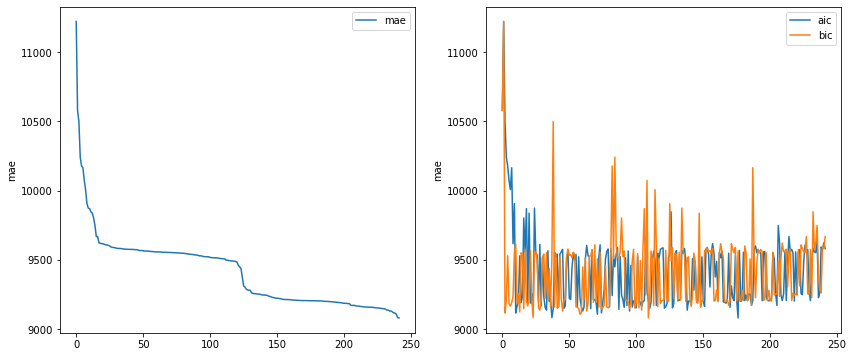

order          aic          bic          mae
232    (9, 0, 6)  9663.083909  9732.712927  9137.424258
233    (6, 0, 5)  9655.110463  9708.356183  9136.874199
234    (6, 0, 7)  9657.818942  9719.256311  9130.239243
235    (7, 0, 7)  9659.969954  9725.503147  9130.233152
236    (9, 0, 8)  9665.204377  9743.025043  9124.102827
237    (7, 0, 6)  9658.918921  9720.356290  9116.763409
238  (10, 0, 10)  9669.251032  9759.359172  9115.660917
239    (8, 0, 5)  9659.344701  9720.782069  9107.305357
240    (9, 0, 7)  9662.462807  9736.187649  9082.817094
241    (7, 0, 4)  9653.249312  9706.495031  9080.258904

In [190]:
fig,axs = plt.subplots(1,2,figsize=(14,6))

sns.lineplot(
    data=grd_res.sort_values('mae', ascending=False).reset_index(drop=True),
    x=grd_res.sort_values('mae', ascending=False).reset_index(drop=True).index,
    y='mae',
    label='mae', ax=axs[0])

sns.lineplot(
    data=grd_res.sort_values('aic', ascending=False).reset_index(drop=True),
    x=grd_res.sort_values('aic', ascending=False).reset_index(drop=True).index,
    y='mae',
    label='aic', ax=axs[1])

sns.lineplot(
    data=grd_res.sort_values('bic', ascending=False).reset_index(drop=True),
    x=grd_res.sort_values('bic', ascending=False).reset_index(drop=True).index,
    y='mae',
    label='bic', ax=axs[1])

plt.show()

grd_res.sort_values(['mae'], ascending=False).reset_index(drop=True).tail(10)


Test MSE: 198864470.464
Test RMSE: 14101.931
Test MAE: 10768.061
Test R2: 0.734


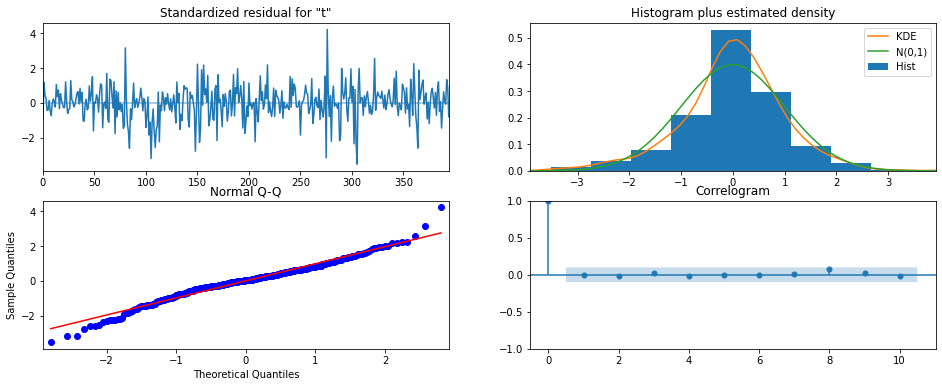

In [196]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

order=(7,0,4)

model = ARIMA(train, order=order)
result = model.fit()

result.plot_diagnostics(figsize=(16,6))

predictions, pred_ci = one_step_forecast(hist1, validate, order)

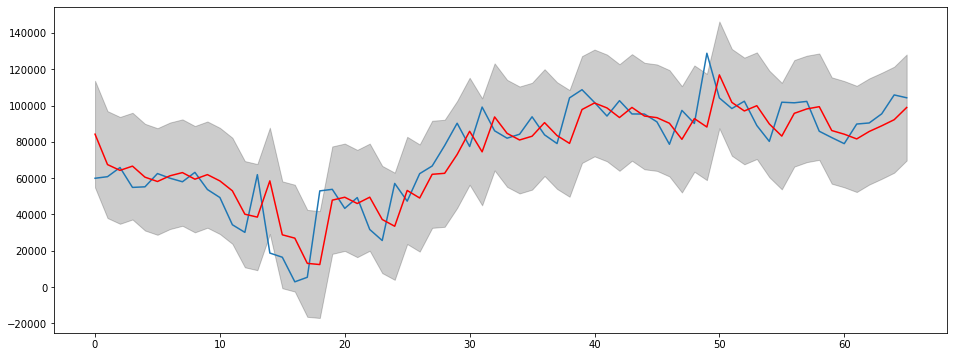

In [197]:
# plot
fig,axs =  plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

axs.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.plot(validate.values)
plt.plot(predictions, color='red')
plt.show()

In [198]:
mape(validate, predictions)

33.30350625063774

## SARIMAX

In [207]:
hist = comgas.set_index('date').totalizador_corrigido.asfreq('D')

size = int(len(hist)*0.8)

train = hist[:size]
test = hist[size:]

order = (5,1,5)

grd_res = gridsearch_SARIMAX(train, order, True)

ValueError: Seasonal periodicity must be greater than 1.

In [205]:
grd_res

Empty DataFrame
Columns: [order, aic, bic, mae]
Index: []

# LSTM - CURIOUS CAT

In [ ]:
def min_max_scaler(X, f_range=(-1,1)):
    scaler = MinMaxScaler(feature_range=f_range)
    scaler = scaler.fit(X)
    return scaler

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


In [255]:

def shift_series(data, lag=1)-> pd.DataFrame:
    """
    This is a helper function to shift the dataset from n-lags.
    
    :param data:
    :param lag: 
    """
    
    df = pd.DataFrame(data)
    
    cols = [df.shift(i) for i in range(1, lag+1)] # n features 
    cols.append(df)
    
    df = pd.concat(cols, axis=1)
    df.fillna(0, inplace=True)
    
    return df.squeeze()

In [1]:
# split train test 
X = comgas.set_index('date').totalizador_corrigido.asfreq('D')
shift = shift_series(X, 1)

size = int(len(X) * 0.80)
train, test = shift[0:size], shift[size:len(X)]

# MinMaxScaler
scaler = min_max_scaler(train)

#scale train
train = train.values.reshape(train.shape[0], train.shape[1])
train_scale = scaler.transform(train)


#scale test
test = test.values.reshape(test.shape[0], test.shape[1])
test_scale = scaler.transform(test)


# fit the model
lstm_model = fit_lstm(train_scale, 1, 1, 4)

NameError: name 'comgas' is not defined

In [ ]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scale[:, 0].reshape(len(train_scale), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()

for i in range(len(test_scale)):
    # make one-step forecast
    X, y = test_scale[i, 0:-1], test_scale[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(ts, yhat, len(test_scale)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = ts[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

mse = mean_squared_error(ts[size:-1], pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(ts[size:-1], pred)
r2 = r2_score(ts[size:-1], pred)

print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

plt.plot(ts[size:], color='blue')
plt.plot(predictions, color='red')
plt.show()

